# Part 1. resilience of the London’s underground
## 1.1 Measures


In [44]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from matplotlib.pyplot import MultipleLocator

In [45]:
G = nx.read_graphml('london.graph.xml')
print(nx.info(G))

Graph with 401 nodes and 467 edges


In [46]:
# To check node attributes:
list(G.nodes(data = True))[0]

('Wembley Park', {'coords': '(519316.5590174915, 186389.32981656672)'})

***
### 1.1.1 Centrality measures

要求：4
1. 选择三种中心度测量方法，
2. 给出定义，
3. 解释在地铁情景下的意义
4. 为什么可以找到对地铁功能最重要的点
5. 计算并给出结果

In [47]:
def cal_centrality(graph,mode):
    '''
    calculate the betweenness centrality of a graph
    mode = degree, betweenness, or closeness
    '''
    if mode == 'degree':
        cen = nx.degree_centrality(graph)
    elif mode == 'betweenness':
        cen = nx.betweenness_centrality(graph, normalized=False)
    elif mode == 'closeness':
        cen = nx.closeness_centrality(graph)

    # We can add these values to the nodes attributes:
    nx.set_node_attributes(graph,cen,mode)

    # To ataframe using the nodes as the index
    df = pd.DataFrame(index=graph.nodes())
    df[mode] = pd.Series(nx.get_node_attributes(graph, mode))
    df_sorted = df.sort_values([mode], ascending=False)
    return df_sorted

In [48]:
pos = nx.get_node_attributes(G, 'coords')

In [49]:
list(G.nodes(data = True))[:5]

[('Wembley Park', {'coords': '(519316.5590174915, 186389.32981656672)'}),
 ('Kingsbury', {'coords': '(519359.9688603217, 188721.22027255083)'}),
 ('Queensbury', {'coords': '(518811.3613368616, 189760.50737704366)'}),
 ('Canons Park', {'coords': '(518183.29968291725, 191257.26260848)'}),
 ('Stanmore', {'coords': '(517580.4596464033, 192537.99948098673)'})]

In [50]:
for node in G.nodes():
    G.nodes[node]['coords'] = eval(G.nodes[node]['coords'])

degree centrality

In [51]:
deg_df = cal_centrality(G,'degree')
deg_df.iloc[:10,:]

,degree
Stratford,0.0225
Bank and Monument,0.0200
King's Cross St. Pancras,0.0175
Baker Street,0.0175
Earl's Court,0.0150
Oxford Circus,0.0150
Liverpool Street,0.0150
Waterloo,0.0150
Green Park,0.0150
Canning Town,0.0150


In [52]:
G_top = G.subgraph(deg_df.index[:10])

topological betweenness centrality

In [53]:
bet_df_sorted = cal_centrality(G,'betweenness')
bet_df_sorted[0:10]

,betweenness
Stratford,23768.093434
Bank and Monument,23181.058947
Liverpool Street,21610.387049
King's Cross St. Pancras,20373.521465
Waterloo,19464.882323
Green Park,17223.622114
Euston,16624.275469
Westminster,16226.155916
Baker Street,15287.107612
Finchley Road,13173.758009


topological closeness centrality

In [54]:
clos_df_sorted = cal_centrality(G,'closeness')
clos_df_sorted[0:10]

,closeness
Green Park,0.114778
Bank and Monument,0.113572
King's Cross St. Pancras,0.113443
Westminster,0.112549
Waterloo,0.112265
Oxford Circus,0.111204
Bond Street,0.110988
Farringdon,0.110742
Angel,0.110742
Moorgate,0.110314


***
### 1.1.2 impact measures

LCC and network efficiency

In [55]:
def cal_LCC_eff(graph):
    '''
    calculate LCC and average global efficiency
    '''
    Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
    Gsub = graph.subgraph(Gcc[0])
    
    # calculate the percentage of nodes present in the largest connected components
    percent_lcc = (len(Gsub.nodes)/len(graph.nodes)) * 100
    avg_global_eff = nx.global_efficiency(graph)
    return percent_lcc,avg_global_eff

1. non-sequential

In [56]:
# we can see in the plot that the graph has more then one component
# let's subset this graph to the largest connected component
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
Gsub = G.subgraph(Gcc[0])

# calculate the percentage of nodes present in the largest connected components
percent_lcc = (len(Gsub.nodes)/len(G.nodes)) * 100

lb = '\n \t'
print(f'Largest Connected Compenent:{percent_lcc:.2f}%')
print(nx.info(Gsub))
print(f'Number of connected components:{nx.number_connected_components(Gsub)}')
print(f"Highest degree nodes: \n \t" \
        f"{lb.join(f'{node[0]}: {node[1]}' for node in sorted(Gsub.degree(), key=lambda pair: pair[1], reverse=True)[0:5])}")

Largest Connected Compenent:100.00%
Graph with 401 nodes and 467 edges
Number of connected components:1
Highest degree nodes: 
 	Stratford: 9
 	Bank and Monument: 8
 	Baker Street: 7
 	King's Cross St. Pancras: 7
 	West Ham: 6


In [57]:
# remove the points form G according to degree centrality
G_rmv_deg = nx.read_graphml('london.graph.xml')
rubost_deg_list = []
for i in range(11):    
    percent_lcc,avg_global_eff = cal_LCC_eff(G_rmv_deg)
    rubost_deg_list.append([percent_lcc,avg_global_eff])
    if i < 10:
        print('moving point:',deg_df.index[i])
        G_rmv_deg.remove_node(deg_df.index[i])

rubost_deg_df = pd.DataFrame(rubost_deg_list,columns = ['LCC','avg eff'])

moving point: Stratford
moving point: Bank and Monument
moving point: King's Cross St. Pancras
moving point: Baker Street
moving point: Earl's Court
moving point: Oxford Circus
moving point: Liverpool Street
moving point: Waterloo
moving point: Green Park
moving point: Canning Town


In [58]:
rubost_deg_df

,LCC,avg eff
0,100.000000,0.101256
1,94.750000,0.088917
2,94.736842,0.085862
3,94.723618,0.080287
4,94.206549,0.075700
5,94.191919,0.074036
6,93.924051,0.072745
7,92.639594,0.070948
8,92.620865,0.068982
9,92.602041,0.068257


In [59]:
# remove the points form G according to degree centrality
G_rmv_deg = nx.read_graphml('london.graph.xml')
rubost_deg_list_seq = []
deg_seq_idx = []
for i in range(11):
    deg_cen_df = cal_centrality(G_rmv_deg,'degree')

    percent_lcc,avg_global_eff = cal_LCC_eff(G_rmv_deg)
    rubost_deg_list_seq.append([percent_lcc,avg_global_eff])
    
    if i < 10:
        print('moving point:',deg_cen_df.index[i])
        deg_seq_idx.append(deg_cen_df.index[i])
        G_rmv_deg.remove_node(deg_cen_df.index[i])
deg_seq_df = pd.DataFrame(rubost_deg_list_seq,columns = ['LCC','avg eff'])

moving point: Stratford
moving point: King's Cross St. Pancras
moving point: Canning Town
moving point: Green Park
moving point: Shadwell
moving point: Liverpool Street
moving point: Turnham Green
moving point: West Hampstead
moving point: Paddington
moving point: Notting Hill Gate


In [60]:
deg_seq_df

,LCC,avg eff
0,100.000000,0.101256
1,94.750000,0.088917
2,94.736842,0.084603
3,91.457286,0.079664
4,91.435768,0.077504
5,91.161616,0.075691
6,91.139241,0.074145
7,91.116751,0.072853
8,91.094148,0.069512
9,91.071429,0.068440


In [61]:
deg_df.index[:10]

Index(['Stratford', 'Bank and Monument', 'King's Cross St. Pancras',
       'Baker Street', 'Earl's Court', 'Oxford Circus', 'Liverpool Street',
       'Waterloo', 'Green Park', 'Canning Town'],
      dtype='object')

In [62]:
deg_seq_idx

['Stratford',
 "King's Cross St. Pancras",
 'Canning Town',
 'Green Park',
 'Shadwell',
 'Liverpool Street',
 'Turnham Green',
 'West Hampstead',
 'Paddington',
 'Notting Hill Gate']

In [63]:
G_top_seq = G.subgraph(deg_seq_idx)

Fig 1. distribution of removed stations according to degree centrality: (a) Non-sequential strategy. (b) Sequential strategy.

<Figure size 600x400 with 0 Axes>

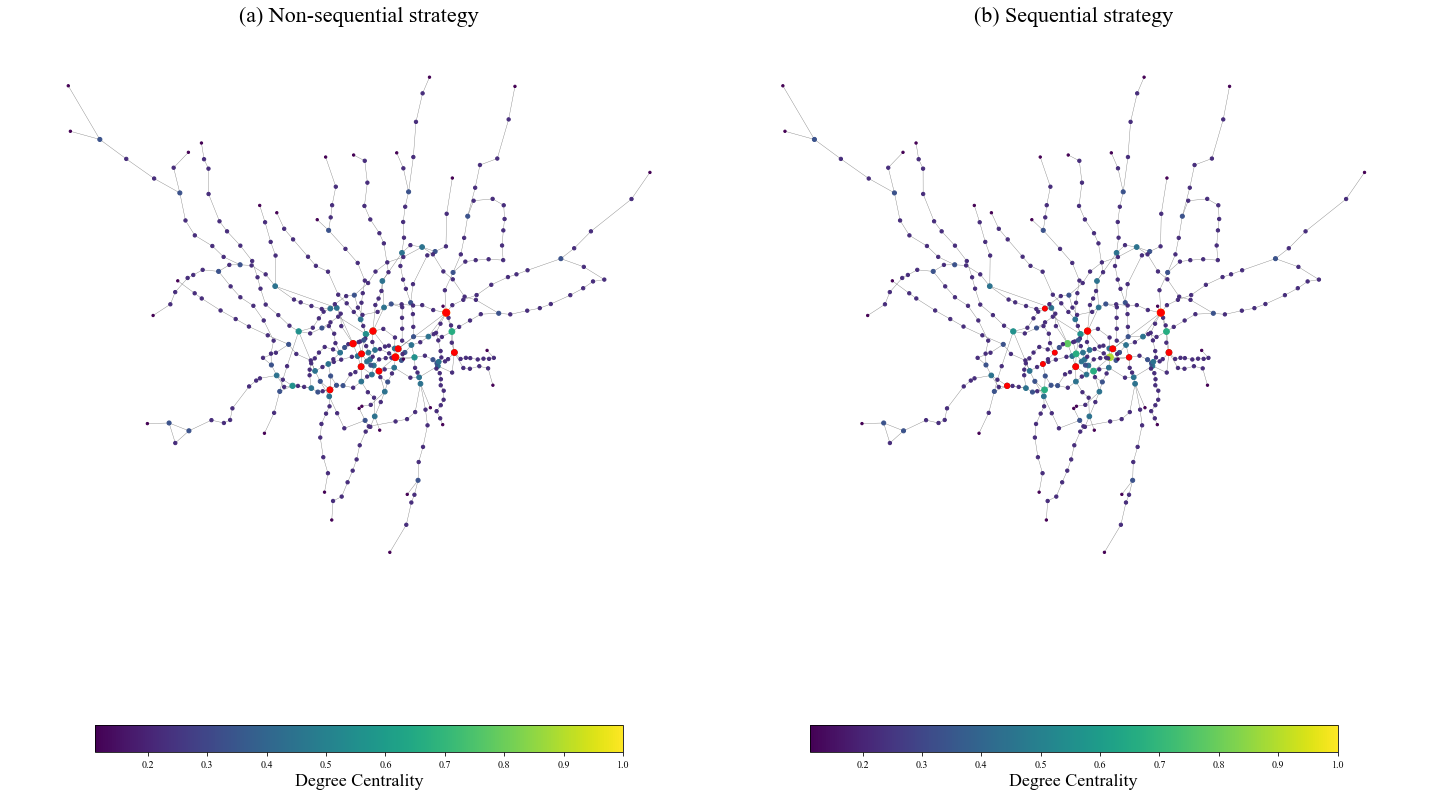

In [64]:
# Lets set colour and size of nodes according to betweenness values
degree_values=[(i[1]['degree']) for i in G.nodes(data=True)]
deg_color=[(i[1]['degree']/(max(degree_values))) for i in G.nodes(data=True)]

deg_size=[(i[1]['degree']/(max(degree_values)))*50 for i in G.nodes(data=True)]
deg_size_sub=[(i[1]['degree']/(max(degree_values)))*50 for i in G_top.nodes(data=True)]
deg_size_seq=[(i[1]['degree']/(max(degree_values)))*50 for i in G_top_seq.nodes(data=True)]


# Plot graph

pos = nx.get_node_attributes(G, 'coords')
plt.figure(dpi=100)
fig, ax = plt.subplots(1,2,figsize=(20,12))
plt.rcParams['font.sans-serif'] = 'Times New Roman'
nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4,ax=ax[0])

nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size,
        ax=ax[0])

nx.draw_networkx_nodes(G_top,
        pos = pos,
        node_color= 'red',
        node_size= deg_size_sub,
        ax=ax[0])

nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4,ax=ax[1])

nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size,
        ax=ax[1])


nx.draw_networkx_nodes(G_top_seq,
        pos = pos,
        node_color= 'red',
        node_size= deg_size_seq,
        ax=ax[1])

cbar1 = plt.colorbar(nod,orientation="horizontal", shrink=0.75,ax=ax[0])
cbar1.set_label("Degree Centrality",fontsize=18)
ax[0].axis("off")
ax[0].set_title("(a) Non-sequential strategy",fontsize=22)

cbar2 = plt.colorbar(nod,label="Degree Centrality",orientation="horizontal", shrink=0.75,ax=ax[1])
cbar2.set_label("Degree Centrality",fontsize=18)
ax[1].axis("off")
ax[1].set_title("(b) Sequential strategy",fontsize=22)
plt.tight_layout()
plt.show()

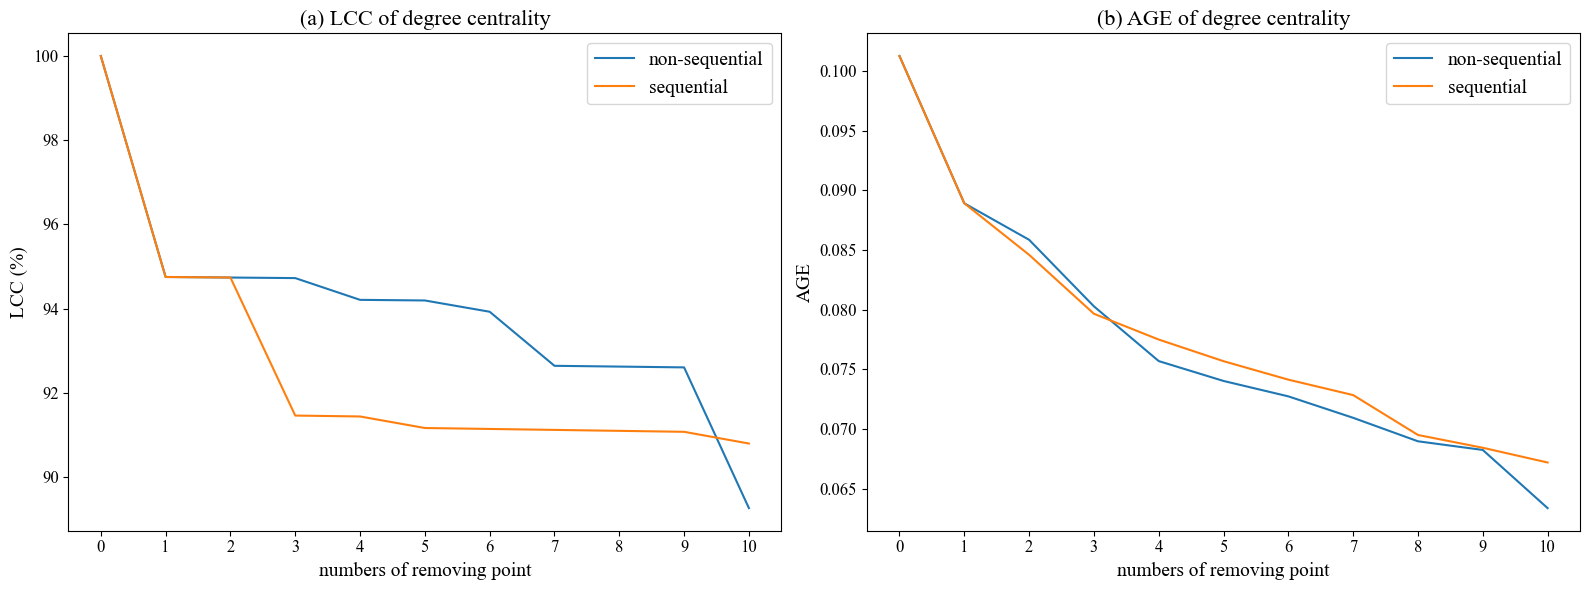

In [65]:
fig, ax = plt.subplots(1,2,figsize=(16,6),dpi=100)
plt.rcParams['font.sans-serif']='Times New Roman'

ax[0].set_title('(a) LCC of degree centrality',fontsize=16)
ax[0].plot(rubost_deg_df.iloc[:,0],label='non-sequential')
ax[0].plot(deg_seq_df.iloc[:,0],label='sequential')
ax[0].set_xlabel('numbers of removing point',fontsize=14)
ax[0].set_ylabel('LCC (%)',fontsize=14)
# ax[0].set_ylabel('LCC (%)',fontsize=14)
ax[0].tick_params(labelsize=12)
ax[0].xaxis.set_major_locator(MultipleLocator(1))
ax[0].legend(fontsize=14)

ax[1].set_title('(b) AGE of degree centrality',fontsize=16)
ax[1].plot(rubost_deg_df.iloc[:,1],label='non-sequential')
ax[1].plot(deg_seq_df.iloc[:,1],label='sequential')
ax[1].set_xlabel('numbers of removing point',fontsize=14)
ax[1].set_ylabel('AGE',fontsize=14)
ax[1].tick_params(labelsize=12)
ax[1].xaxis.set_major_locator(MultipleLocator(1))
ax[1].legend(fontsize=14)


plt.tight_layout()
plt.show()

***
betweenness

In [66]:
# remove the points form G according to betweenness centrality
G_rmv_bet = nx.read_graphml('london.graph.xml')
rubost_bet_list = []
for i in range(11):
    percent_lcc,avg_global_eff = cal_LCC_eff(G_rmv_bet)
    rubost_bet_list.append([percent_lcc,avg_global_eff])
    if i < 10:
        print('moving point:',bet_df_sorted.index[i])
        G_rmv_bet.remove_node(bet_df_sorted.index[i])
rubost_bet_df = pd.DataFrame(rubost_bet_list,columns = ['LCC','avg eff'])

moving point: Stratford
moving point: Bank and Monument
moving point: Liverpool Street
moving point: King's Cross St. Pancras
moving point: Waterloo
moving point: Green Park
moving point: Euston
moving point: Westminster
moving point: Baker Street
moving point: Finchley Road


In [67]:
rubost_bet_df

,LCC,avg eff
0,100.000000,0.101256
1,94.750000,0.088917
2,94.736842,0.085862
3,94.723618,0.084963
4,93.450882,0.078498
5,93.434343,0.075942
6,93.417722,0.074152
7,87.817259,0.068206
8,87.786260,0.067660
9,87.244898,0.064700


In [68]:
G_rmv_bet = nx.read_graphml('london.graph.xml')
bet_seq_idx = []
bet_list_seq = []
for i in range(11):
    bet_df_sorted = cal_centrality(G_rmv_bet,'betweenness')

    percent_lcc,avg_global_eff = cal_LCC_eff(G_rmv_bet)
    bet_list_seq.append([percent_lcc,avg_global_eff])
    
    if i < 10:
        print('moving point:',bet_df_sorted.index[0])
        bet_seq_idx.append(bet_df_sorted.index[0])
        G_rmv_bet.remove_node(bet_df_sorted.index[0])
bet_seq_df = pd.DataFrame(bet_list_seq,columns = ['LCC','avg eff'])

moving point: Stratford
moving point: King's Cross St. Pancras
moving point: Waterloo
moving point: Bank and Monument
moving point: Canada Water
moving point: West Hampstead
moving point: Earl's Court
moving point: Shepherd's Bush
moving point: Euston
moving point: Baker Street


In [69]:
bet_seq_df

,LCC,avg eff
0,100.000000,0.101256
1,94.750000,0.088917
2,94.736842,0.084603
3,94.723618,0.081829
4,94.710327,0.077678
5,94.696970,0.072832
6,57.468354,0.053210
7,57.360406,0.051656
8,49.872774,0.045844
9,44.132653,0.041631


In [70]:
bet_df_sorted = cal_centrality(G,'betweenness')

<Figure size 600x400 with 0 Axes>

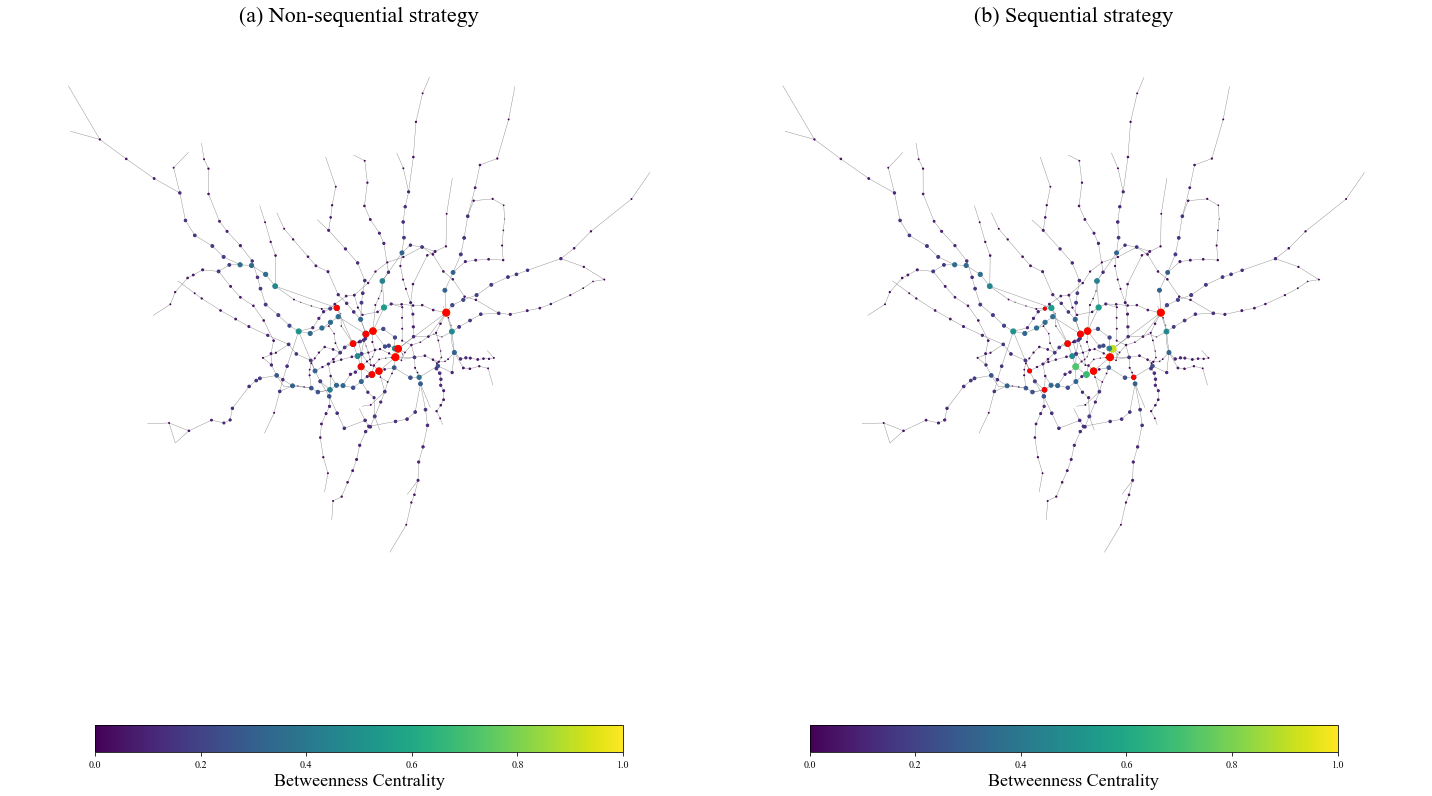

In [71]:
G_top = G.subgraph(bet_df_sorted.index[:10])
G_top_seq = G.subgraph(bet_seq_idx)
# Lets set colour and size of nodes according to betweenness values
degree_values=[(i[1]['betweenness']) for i in G.nodes(data=True)]
deg_color=[(i[1]['betweenness']/(max(degree_values))) for i in G.nodes(data=True)]

deg_size=[(i[1]['betweenness']/(max(degree_values)))*50 for i in G.nodes(data=True)]
deg_size_sub=[(i[1]['betweenness']/(max(degree_values)))*50 for i in G_top.nodes(data=True)]
deg_size_seq=[(i[1]['betweenness']/(max(degree_values)))*50 for i in G_top_seq.nodes(data=True)]


# Plot graph

pos = nx.get_node_attributes(G, 'coords')
plt.figure(dpi=100)
fig, ax = plt.subplots(1,2,figsize=(20,12))
plt.rcParams['font.sans-serif'] = 'Times New Roman'
nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4,ax=ax[0])

nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size,
        ax=ax[0])

nx.draw_networkx_nodes(G_top,
        pos = pos,
        node_color= 'red',
        node_size= deg_size_sub,
        ax=ax[0])

nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4,ax=ax[1])

nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size,
        ax=ax[1])


nx.draw_networkx_nodes(G_top_seq,
        pos = pos,
        node_color= 'red',
        node_size= deg_size_seq,
        ax=ax[1])

cbar1 = plt.colorbar(nod,orientation="horizontal", shrink=0.75,ax=ax[0])
cbar1.set_label("Betweenness Centrality",fontsize=18)
ax[0].axis("off")
ax[0].set_title("(a) Non-sequential strategy",fontsize=22)

cbar2 = plt.colorbar(nod,label="Degree Centrality",orientation="horizontal", shrink=0.75,ax=ax[1])
cbar2.set_label("Betweenness Centrality",fontsize=18)
ax[1].axis("off")
ax[1].set_title("(b) Sequential strategy",fontsize=22)
plt.tight_layout()
plt.show()

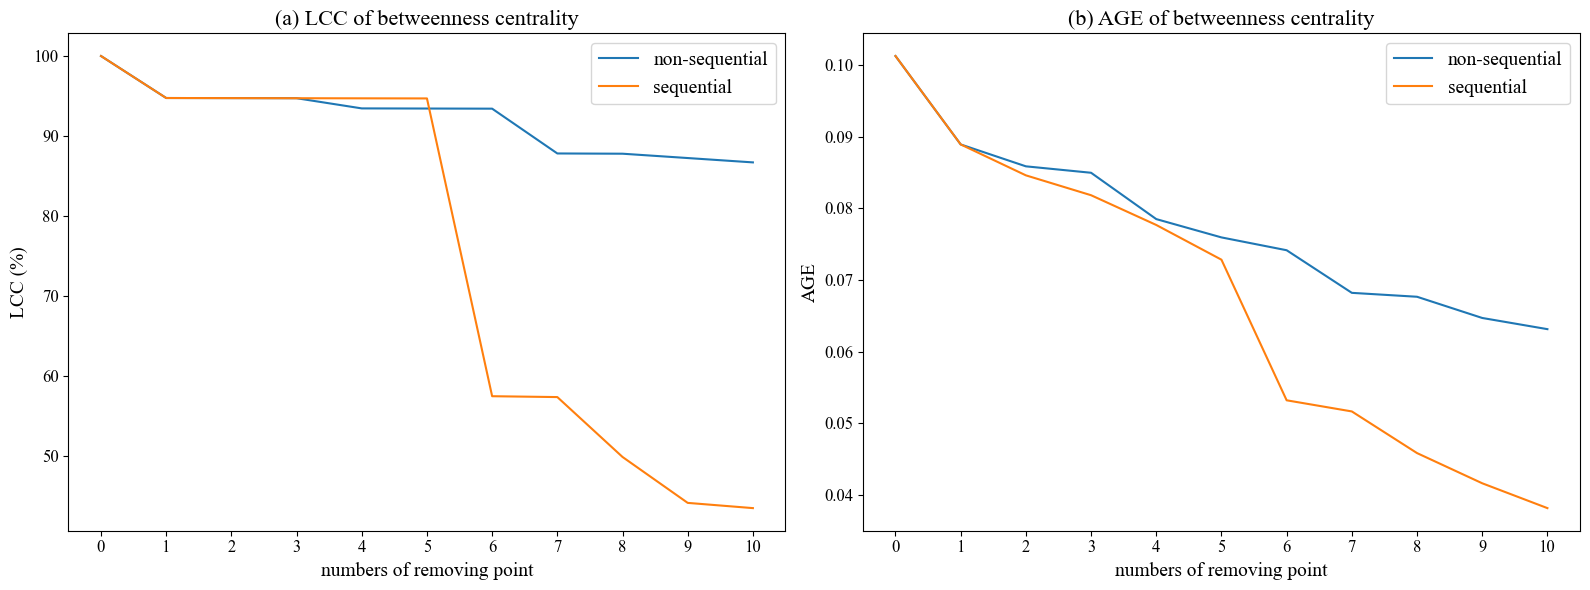

In [72]:
fig, ax = plt.subplots(1,2,figsize=(16,6),dpi=100)
plt.rcParams['font.sans-serif']='Times New Roman'

ax[0].set_title('(a) LCC of betweenness centrality',fontsize=16)
ax[0].plot(rubost_bet_df.iloc[:,0],label='non-sequential')
ax[0].plot(bet_seq_df.iloc[:,0],label='sequential')
ax[0].set_xlabel('numbers of removing point',fontsize=14)
ax[0].set_ylabel('LCC (%)',fontsize=14)
# ax[0].set_ylabel('LCC (%)',fontsize=14)
ax[0].tick_params(labelsize=12)
ax[0].xaxis.set_major_locator(MultipleLocator(1))
ax[0].legend(fontsize=14)

ax[1].set_title('(b) AGE of betweenness centrality',fontsize=16)
ax[1].plot(rubost_bet_df.iloc[:,1],label='non-sequential')
ax[1].plot(bet_seq_df.iloc[:,1],label='sequential')
ax[1].set_xlabel('numbers of removing point',fontsize=14)
ax[1].set_ylabel('AGE',fontsize=14)
ax[1].tick_params(labelsize=12)
ax[1].xaxis.set_major_locator(MultipleLocator(1))
ax[1].legend(fontsize=14)


plt.tight_layout()
plt.show()

In [73]:
[i for i in bet_seq_idx if i in bet_df_sorted.index[:10]]

['Stratford',
 "King's Cross St. Pancras",
 'Waterloo',
 'Bank and Monument',
 'Euston',
 'Baker Street']

***
closeness 

In [74]:
# remove the points form G according to closeness centrality
G_rmv_clos = nx.read_graphml('london.graph.xml')
rubost_clos_list = []
for i in range(11):
    percent_lcc,avg_global_eff = cal_LCC_eff(G_rmv_clos)
    rubost_clos_list.append([percent_lcc,avg_global_eff])
    if i < 10:
        print('moving point:',clos_df_sorted.index[i])
        G_rmv_clos.remove_node(clos_df_sorted.index[i])
rubost_clos_df = pd.DataFrame(rubost_clos_list,columns = ['LCC','avg eff'])

moving point: Green Park
moving point: Bank and Monument
moving point: King's Cross St. Pancras
moving point: Westminster
moving point: Waterloo
moving point: Oxford Circus
moving point: Bond Street
moving point: Farringdon
moving point: Angel
moving point: Moorgate


In [75]:
rubost_clos_df

,LCC,avg eff
0,100.000000,0.101256
1,100.000000,0.099190
2,100.000000,0.094872
3,100.000000,0.087934
4,100.000000,0.087372
5,100.000000,0.084859
6,100.000000,0.082781
7,100.000000,0.082581
8,100.000000,0.082600
9,100.000000,0.082622


In [76]:
G_rmv_clos = nx.read_graphml('london.graph.xml')
rubost_clos_list_seq = []
clos_seq_idx = []
for i in range(11):
    clos_df_sorted = cal_centrality(G_rmv_clos,'closeness')

    percent_lcc,avg_global_eff = cal_LCC_eff(G_rmv_clos)
    rubost_clos_list_seq.append([percent_lcc,avg_global_eff])
    
    if i < 10:
        print('moving point:',clos_df_sorted.index[0])
        clos_seq_idx.append(clos_df_sorted.index[0])
        G_rmv_clos.remove_node(clos_df_sorted.index[0])
clos_seq_df = pd.DataFrame(rubost_clos_list_seq,columns = ['LCC','avg eff'])

moving point: Green Park
moving point: King's Cross St. Pancras
moving point: Waterloo
moving point: Bank and Monument
moving point: West Hampstead
moving point: Canada Water
moving point: Stratford
moving point: Earl's Court
moving point: Shepherd's Bush
moving point: Oxford Circus


In [77]:
clos_seq_df

,LCC,avg eff
0,100.000000,0.101256
1,100.000000,0.099190
2,100.000000,0.094435
3,100.000000,0.091816
4,100.000000,0.085426
5,100.000000,0.080544
6,57.215190,0.058101
7,57.360406,0.051884
8,57.251908,0.050350
9,49.744898,0.044395


In [78]:
clos_df_sorted = cal_centrality(G,'closeness')
[i for i in clos_seq_idx if i in clos_df_sorted.index[:10]]

['Green Park',
 "King's Cross St. Pancras",
 'Waterloo',
 'Bank and Monument',
 'Oxford Circus']

<Figure size 600x400 with 0 Axes>

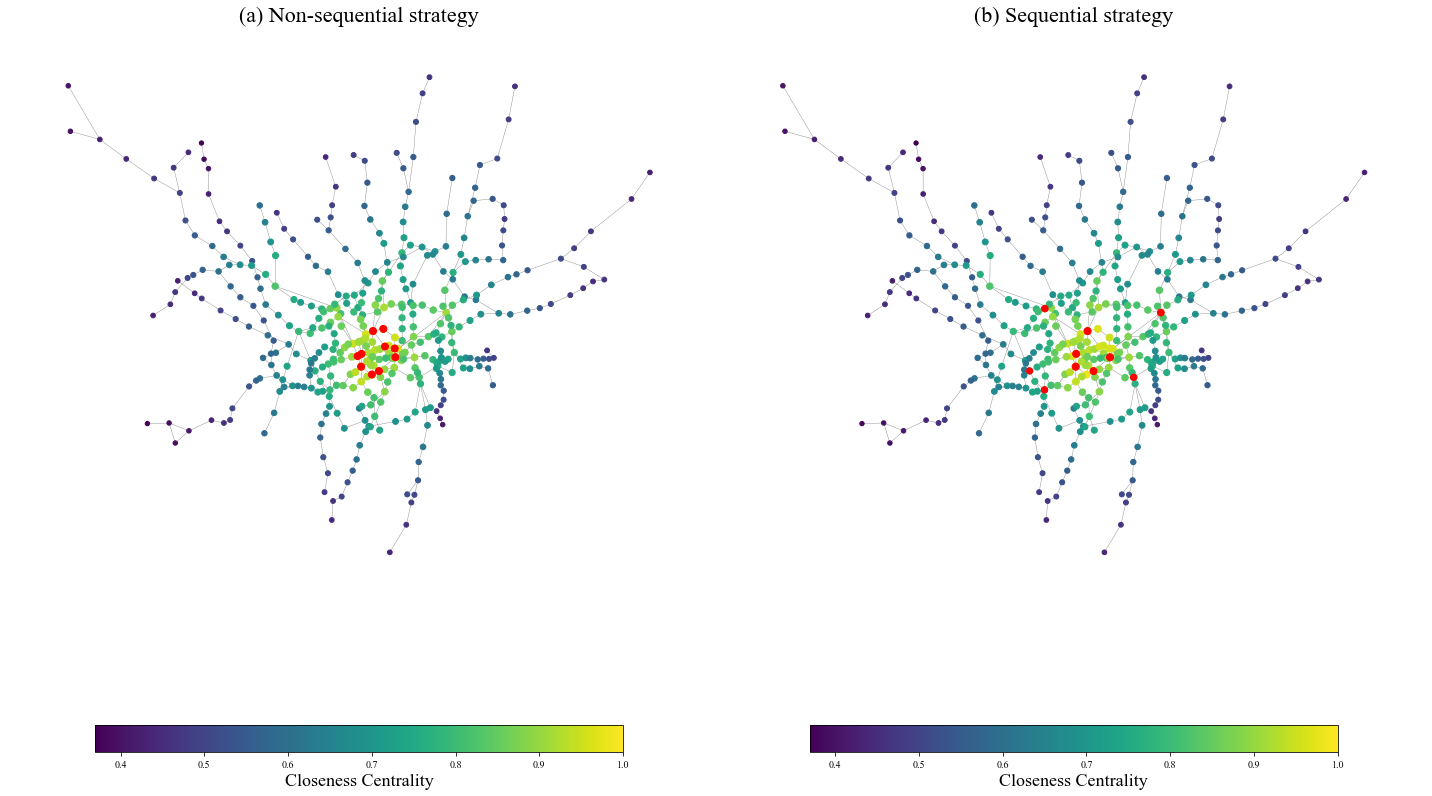

In [79]:
G_top = G.subgraph(clos_df_sorted.index[:10])
G_top_seq = G.subgraph(clos_seq_idx)
# Lets set colour and size of nodes according to betweenness values
degree_values=[(i[1]['closeness']) for i in G.nodes(data=True)]
deg_color=[(i[1]['closeness']/(max(degree_values))) for i in G.nodes(data=True)]

deg_size=[(i[1]['closeness']/(max(degree_values)))*50 for i in G.nodes(data=True)]
deg_size_sub=[(i[1]['closeness']/(max(degree_values)))*50 for i in G_top.nodes(data=True)]
deg_size_seq=[(i[1]['closeness']/(max(degree_values)))*50 for i in G_top_seq.nodes(data=True)]


# Plot graph

pos = nx.get_node_attributes(G, 'coords')
plt.figure(dpi=100)
fig, ax = plt.subplots(1,2,figsize=(20,12))
plt.rcParams['font.sans-serif'] = 'Times New Roman'
nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4,ax=ax[0])

nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size,
        ax=ax[0])

nx.draw_networkx_nodes(G_top,
        pos = pos,
        node_color= 'red',
        node_size= deg_size_sub,
        ax=ax[0])

nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4,ax=ax[1])

nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size,
        ax=ax[1])


nx.draw_networkx_nodes(G_top_seq,
        pos = pos,
        node_color= 'red',
        node_size= deg_size_seq,
        ax=ax[1])

cbar1 = plt.colorbar(nod,orientation="horizontal", shrink=0.75,ax=ax[0])
cbar1.set_label("Closeness Centrality",fontsize=18)
ax[0].axis("off")
ax[0].set_title("(a) Non-sequential strategy",fontsize=22)

cbar2 = plt.colorbar(nod,orientation="horizontal", shrink=0.75,ax=ax[1])
cbar2.set_label("Closeness Centrality",fontsize=18)
ax[1].axis("off")
ax[1].set_title("(b) Sequential strategy",fontsize=22)
plt.tight_layout()
plt.show()

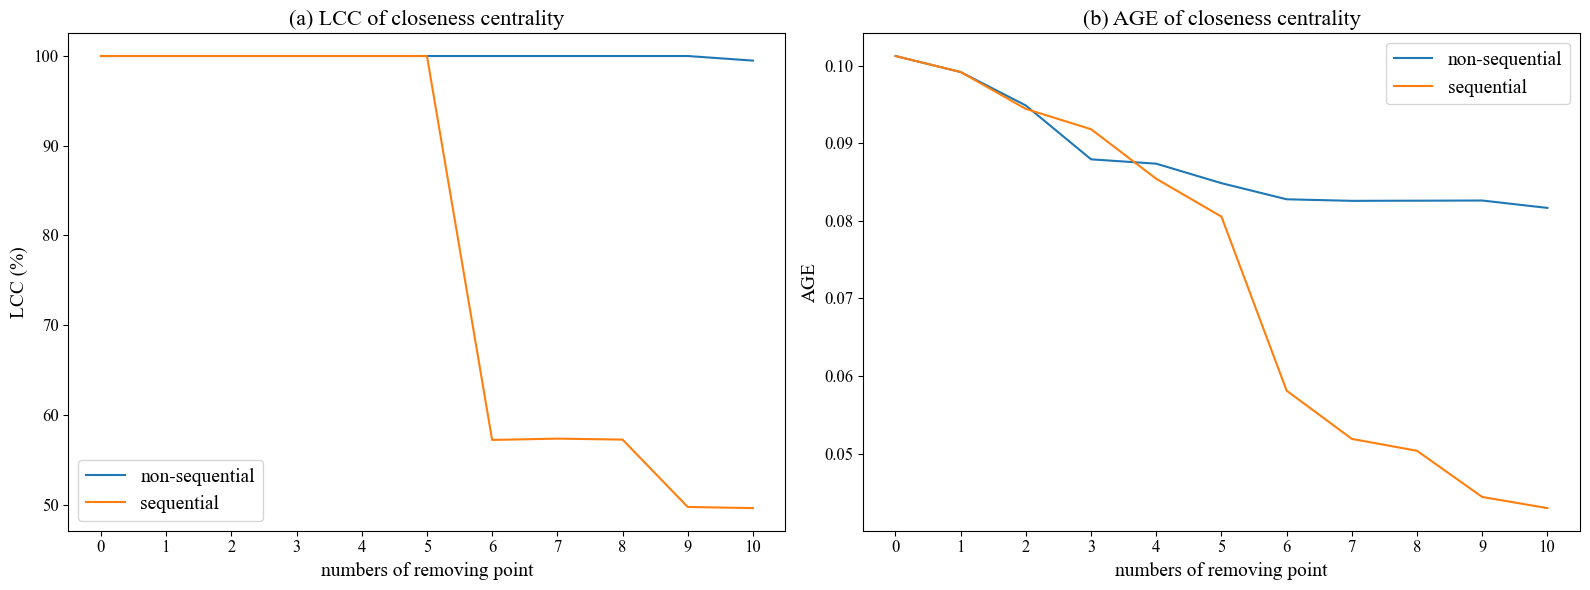

In [80]:
fig, ax = plt.subplots(1,2,figsize=(16,6),dpi=100)
plt.rcParams['font.sans-serif']='Times New Roman'

ax[0].set_title('(a) LCC of closeness centrality',fontsize=16)
ax[0].plot(rubost_clos_df.iloc[:,0],label='non-sequential')
ax[0].plot(clos_seq_df.iloc[:,0],label='sequential')
ax[0].set_xlabel('numbers of removing point',fontsize=14)
ax[0].set_ylabel('LCC (%)',fontsize=14)
# ax[0].set_ylabel('LCC (%)',fontsize=14)
ax[0].tick_params(labelsize=12)
ax[0].xaxis.set_major_locator(MultipleLocator(1))
ax[0].legend(fontsize=14)

ax[1].set_title('(b) AGE of closeness centrality',fontsize=16)
ax[1].plot(rubost_clos_df.iloc[:,1],label='non-sequential')
ax[1].plot(clos_seq_df.iloc[:,1],label='sequential')
ax[1].set_xlabel('numbers of removing point',fontsize=14)
ax[1].set_ylabel('AGE',fontsize=14)
ax[1].tick_params(labelsize=12)
ax[1].xaxis.set_major_locator(MultipleLocator(1))
ax[1].legend(fontsize=14)


plt.tight_layout()
plt.show()

***
## 2. Flows: weighted network

In [81]:
london_flow = pd.read_csv('london_flows.csv')
london_flow.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [95]:
G2 = nx.read_graphml("london.graph.xml")

inv_flows={(e1, e2):round(1./(flows + 0.0001),7) for e1, e2, flows in G2.edges(data='flows')}
# Let us add the inversed weight as an attribute to the edges in the graph
nx.set_edge_attributes(G2, inv_flows, 'inv_flows')

cen = nx.betweenness_centrality(G2, normalized=False, weight='inv_flows')


# We can add these values to the nodes attributes:
nx.set_node_attributes(G2,cen,'betweenness_w')

# To ataframe using the nodes as the index
bet_w = pd.DataFrame(index=G2.nodes())
bet_w['betweenness_w'] = pd.Series(nx.get_node_attributes(G2, 'betweenness_w'))
bet_w = bet_w.sort_values(['betweenness_w'], ascending=False)

In [96]:
bet_w[:10]

,betweenness_w
Green Park,45690.0
Bank and Monument,40322.0
Waterloo,33231.0
Westminster,30433.0
Liverpool Street,26878.0
Stratford,26437.0
Bond Street,23288.0
Euston,22682.0
Oxford Circus,21607.0
Warren Street,20292.0


<Figure size 600x400 with 0 Axes>

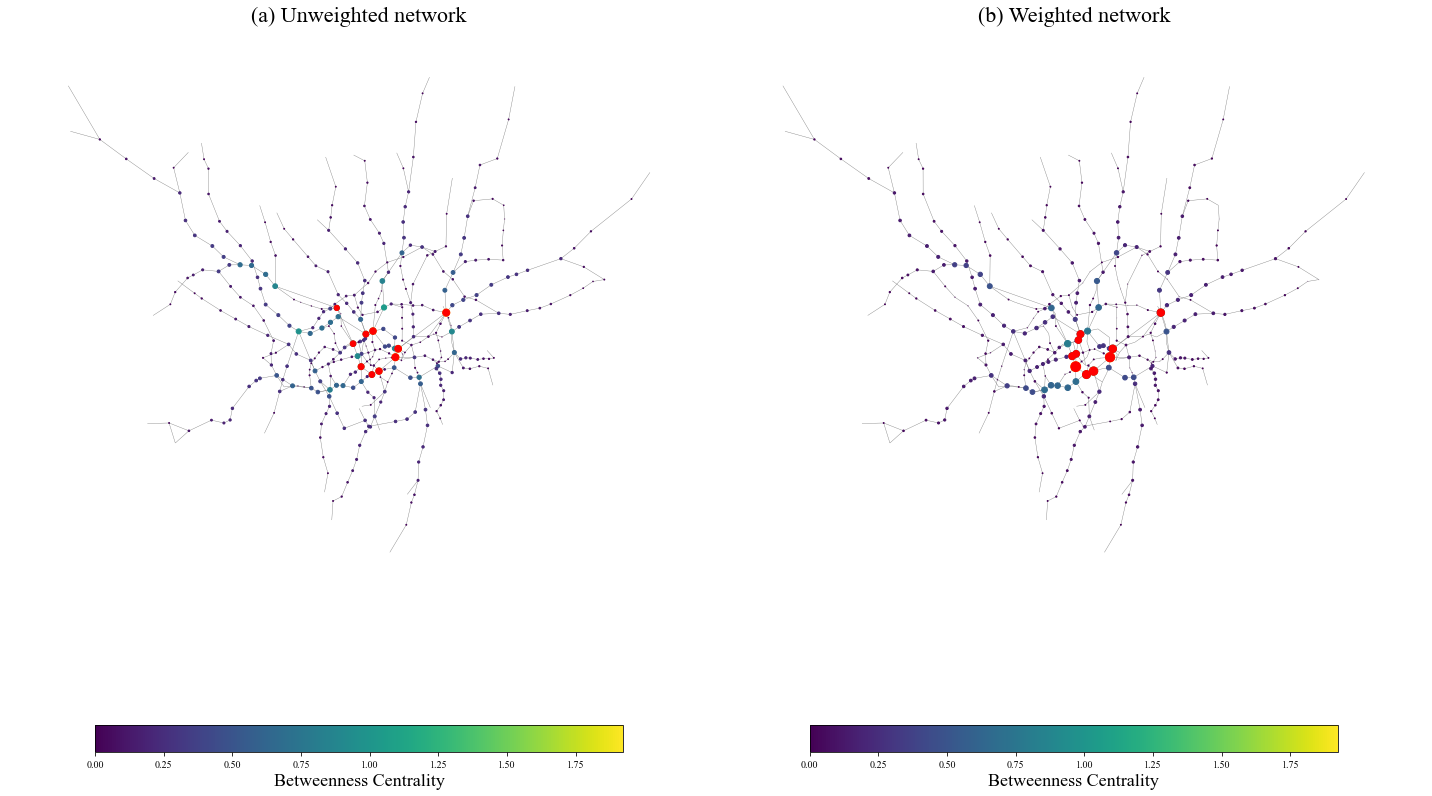

In [97]:
bet_df_sorted = cal_centrality(G,'betweenness')
G_unweight = G.subgraph(bet_df_sorted.index[:10])
G_weight = G2.subgraph(bet_w.index[:10])

# Lets set colour and size of nodes according to betweenness values
degree_values=[(i[1]['betweenness']) for i in G.nodes(data=True)]
deg_color=[(i[1]['betweenness']/(max(degree_values))) for i in G.nodes(data=True)]
deg_size=[(i[1]['betweenness']/(max(degree_values)))*50 for i in G.nodes(data=True)]

# weight
wei_degree_values=[(i[1]['betweenness_w']) for i in G2.nodes(data=True)]
wei_deg_color=[(i[1]['betweenness_w']/(max(degree_values))) for i in G2.nodes(data=True)]
wei_deg_size=[(i[1]['betweenness_w']/(max(degree_values)))*50 for i in G2.nodes(data=True)]

bet_size_unwei=[(i[1]['betweenness']/(max(degree_values)))*50 for i in G_unweight.nodes(data=True)]
bet_size_wei=[(i[1]['betweenness_w']/(max(degree_values)))*50 for i in G_weight.nodes(data=True)]


# Plot graph

pos = nx.get_node_attributes(G, 'coords')
plt.figure(dpi=100)
fig, ax = plt.subplots(1,2,figsize=(20,12))
plt.rcParams['font.sans-serif'] = 'Times New Roman'
nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4,ax=ax[0])

nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size,
        ax=ax[0])

nx.draw_networkx_nodes(G_unweight,
        pos = pos,
        node_color= 'red',
        node_size= bet_size_unwei,
        ax=ax[0])

nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4,ax=ax[1])

nod=nx.draw_networkx_nodes(G2,
        pos = pos,
        node_color= wei_deg_color,
        node_size= wei_deg_size,
        ax=ax[1])


nx.draw_networkx_nodes(G_weight,
        pos = pos,
        node_color= 'red',
        node_size= bet_size_wei,
        ax=ax[1])

cbar1 = plt.colorbar(nod,orientation="horizontal", shrink=0.75,ax=ax[0])
cbar1.set_label("Betweenness Centrality",fontsize=18)
ax[0].axis("off")
ax[0].set_title("(a) Unweighted network",fontsize=22)

cbar2 = plt.colorbar(nod,orientation="horizontal", shrink=0.75,ax=ax[1])
cbar2.set_label("Betweenness Centrality",fontsize=18)
ax[1].axis("off")
ax[1].set_title("(b) Weighted network",fontsize=22)
plt.tight_layout()
plt.show()

In [98]:
def cal_avg_short_path(graph,weight):
    '''
    calculate the average shortest path
    '''
    short_dis = 0
    Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
    for i in range(len(Gcc)):
        dis = nx.average_shortest_path_length(graph.subgraph(Gcc[i]), weight=weight, method=None)
        short_dis += dis

    return short_dis


In [100]:
G2 = nx.read_graphml("london.graph.xml")

inv_flows={(e1, e2):round(1./(flows + 0.0001),7) for e1, e2, flows in G2.edges(data='flows')}
# Let us add the inversed weight as an attribute to the edges in the graph
nx.set_edge_attributes(G2, inv_flows, 'inv_flows')
# nx.average_shortest_path_length(G2)

avg_clust_bef = nx.average_clustering(G2,weight='inv_flows')
wei_bef = nx.average_shortest_path_length(G2,weight='inv_flows')

print('weighted, before removing, cluster',avg_clust_bef)
print('weighted, before removing, shortest path',wei_bef)


G2.remove_nodes_from(['Green Park'])

avg_clust_aft = nx.average_clustering(G2,weight='inv_flows')
wei_aft = nx.average_shortest_path_length(G2,weight='inv_flows')

print('weighted, after removing, cluster',avg_clust_aft)
print('weighted, after removing, shortest path',wei_aft)


wei_ratio = (wei_aft - wei_bef) / wei_bef
clust_ratio = (avg_clust_aft - avg_clust_bef) / avg_clust_bef

print(f'change rate of path {wei_ratio:.2%}')
print(f'change rate of cluster {clust_ratio:.2%}')

weighted, before removing, cluster 7.489652415674562e-10
weighted, before removing, shortest path 199.25268179074288
weighted, after removing, cluster 7.551012931612478e-10
weighted, after removing, shortest path 199.75021251871163
change rate of path 0.25%
change rate of cluster 0.82%


In [101]:
G3 = nx.read_graphml("london.graph.xml")

# Print edge list with attributes
print(list(G3.edges(data = True))[0])

avg_clust_bef = nx.average_clustering(G3)
wei_bef = nx.average_shortest_path_length(G3)

print('unweighted, before removing, cluster',avg_clust_bef)
print('unweighted, before removing, shortest path',wei_bef)


G3.remove_nodes_from(['Stratford'])

avg_clust_aft = nx.average_clustering(G3)
# wei_aft = cal_avg_short_path(G3,None)
Gcc = sorted(nx.connected_components(G3), key=len, reverse=True)
dis = nx.average_shortest_path_length(G3.subgraph(Gcc[0]), method=None)

print('unweighted, after removing, cluster',avg_clust_aft)
print('unweighted, after removing, shortest path',dis)


wei_ratio = (dis - wei_bef) / wei_bef
clust_ratio = (avg_clust_aft - avg_clust_bef) / avg_clust_bef

print(f'change rate of path {wei_ratio:.2%}')
print(f'change rate of cluster {clust_ratio:.2%}')

('Wembley Park', 'Kingsbury', {'length': 2916.7715580506483, 'line_name': 'Jubilee', 'flows': 12356})
unweighted, before removing, cluster 0.030382377389858693
unweighted, before removing, shortest path 13.545997506234414
unweighted, after removing, cluster 0.030625000000000003
unweighted, after removing, shortest path 14.496447069006436
change rate of path 7.02%
change rate of cluster 0.80%


***

## part 3 models and calibration


In [102]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math
import scipy.stats
from math import sqrt


In [104]:
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

def data_preprocess(df):
    '''
    data preprocess
    '''
    df = df[df['population'] != 0]
    df = df[df['jobs'] != 0]
    df = df[df['distance'] != 0]
    df = df.reset_index()

    df['log_pop'] = df['population']
    df['log_jobs'] = df['jobs']
    df['log_dis'] = df['distance']

    df['log_pop'] = df['log_pop'].apply(lambda x: math.log(x))
    df['log_jobs'] = df['log_jobs'].apply(lambda x: math.log(x))
    df['log_dis'] = df['log_dis'].apply(lambda x: math.log(x))
    return df

In [105]:
london_flow_un = pd.read_csv('london_flows.csv')
london_flow_un = data_preprocess(london_flow_un)
london_flow_un.head()

,index,station_origin,station_destination,flows,population,jobs,distance,log_pop,log_jobs,log_dis
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504
1,1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274


In [106]:
#create the formula
#inverse power
formula_unconstrain_inv_power = 'flows ~ log_pop + log_jobs + log_dis'  #dis
#run the regression
uncosim_inv_power = smf.glm(formula = formula_unconstrain_inv_power, 
                    data=london_flow_un, 
                    family=sm.families.Poisson()).fit()

#create the formula
#negative distance
formula_unconstrain_nega_dis = 'flows ~ log_pop + log_jobs + distance'  #dis
#run the regression
uncosim_nega_dis = smf.glm(formula = formula_unconstrain_nega_dis, 
                    data=london_flow_un, 
                    family=sm.families.Poisson()).fit()

In [107]:
print('inverse power')
print(uncosim_inv_power.summary())

inverse power
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61409
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2785e+06
Date:                Mon, 02 May 2022   Deviance:                   2.3848e+06
Time:                        18:23:57   Pearson chi2:                 4.76e+06
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.7475      0.014   -27

In [108]:
K = uncosim_inv_power.params[0]
alpha = uncosim_inv_power.params[1]
gamma = uncosim_inv_power.params[2]
beta = -uncosim_inv_power.params[3]
print('inverse power')
print(f'K = {K}')
print(f'alpha = {alpha}')
print(f'gamma = {gamma}')
print(f'beta = {beta}')

inverse power
K = -3.747520395557361
alpha = 0.7324738922938159
gamma = 0.760762035185629
beta = 0.622802055290168


K=-3.7475, K= lnk

$\alpha$=0.7325, $\gamma$=0.7608, $\beta$=0.6228

In [109]:
print('negative distance')
print(uncosim_nega_dis.summary())

negative distance
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61409
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2445e+06
Date:                Mon, 02 May 2022   Deviance:                   2.3168e+06
Time:                        18:24:04   Pearson chi2:                 4.41e+06
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.9332      0.010  

In [110]:
K = uncosim_nega_dis.params[0]
alpha = uncosim_nega_dis.params[1]
gamma = uncosim_nega_dis.params[2]
beta = -uncosim_nega_dis.params[3]
print('inverse power')
print(f'K = {K}')
print(f'alpha = {alpha}')
print(f'gamma = {gamma}')
print(f'beta = {beta}')

inverse power
K = -7.933159072736528
alpha = 0.7027647840654677
gamma = 0.7363952004252503
beta = 9.036708790738086e-05


In [ ]:
#first assign the parameter values from the model to the appropriate variables
K = uncosim_inv_power.params[0]
alpha = uncosim_inv_power.params[1]
gamma = uncosim_inv_power.params[2]
beta = -uncosim_inv_power.params[3]

#now plug everything back into the Equation 6 model ... 
#be careful with the negative signing of the parameter beta
est = np.exp(K 
            + alpha*london_flow_un["log_pop"] 
            + gamma*london_flow_un["log_jobs"] 
            - beta*london_flow_un["log_dis"])

#or we can just extract the results from the actual poisson regression and apply them to the data
predictions = uncosim_inv_power.get_prediction()
predictions_summary_frame = predictions.summary_frame()
london_flow_un["est_inv_power"] = predictions_summary_frame["mean"]

K = uncosim_nega_dis.params[0]
alpha = uncosim_nega_dis.params[1]
gamma = uncosim_nega_dis.params[2]
beta = -uncosim_nega_dis.params[3]

#now plug everything back into the Equation 6 model ... 
#be careful with the negative signing of the parameter beta
est = np.exp(K 
                                       + alpha*london_flow_un["log_pop"] 
                                       + gamma*london_flow_un["log_jobs"] 
                                       - beta*london_flow_un["distance"])

#or we can just extract the results from the actual poisson regression and apply them to the data
predictions = uncosim_nega_dis.get_prediction()
predictions_summary_frame = predictions.summary_frame()
london_flow_un["est_nega_dis"] = predictions_summary_frame["mean"]

In [ ]:
london_flow_un.head()

,index,station_origin,station_destination,flows,population,jobs,distance,log_pop,log_jobs,log_dis,est_inv_power,est_nega_dis
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,49.617996,61.969700
1,1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,0.937195,1.320198
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,2.121375,2.735847
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,53.297014,65.905222
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,32.208586,31.865850


In [ ]:
R2 = CalcRSqaured(london_flow_un["flows"], london_flow_un["est_inv_power"])
RMSE = CalcRMSE(london_flow_un["flows"], london_flow_un["est_inv_power"])
print('unconstrained model, inverse power')
print(f'R2={R2:0.2f}, RMSE={RMSE:0.2f}')

R2 = CalcRSqaured(london_flow_un["flows"], london_flow_un["est_nega_dis"])
RMSE = CalcRMSE(london_flow_un["flows"], london_flow_un["est_nega_dis"])
print('unconstrained model, negative distance')
print(f'R2={R2:0.2f}, RMSE={RMSE:0.2f}')

unconstrained model, inverse power
R2=0.32, RMSE=108.33
unconstrained model, negative distance
R2=0.36, RMSE=105.72


***
origin-constrained model

In [ ]:
london_flow_origin = pd.read_csv('london_flows.csv')
london_flow_origin = london_flow_origin[london_flow_origin['jobs'] != 0]
london_flow_origin = london_flow_origin[london_flow_origin['distance'] != 0]
london_flow_origin = london_flow_origin.reset_index()

london_flow_origin['log_jobs'] = london_flow_origin['jobs']
london_flow_origin['log_dis'] = london_flow_origin['distance']

london_flow_origin['log_jobs'] = london_flow_origin['log_jobs'].apply(lambda x: math.log(x))
london_flow_origin['log_dis'] = london_flow_origin['log_dis'].apply(lambda x: math.log(x))

In [ ]:
formula_inv_power = 'flows ~ station_origin + log_jobs + log_dis -1' 
ori_cosim_inv_power = smf.glm(formula = formula_inv_power, data=london_flow_origin, family=sm.families.Poisson()).fit()
#print(prodsim.summary())

formula_nega_dis = 'flows ~ station_origin + log_jobs + distance -1' 
ori_cosim_nega_dis = smf.glm(formula = formula_nega_dis, data=london_flow_origin, family=sm.families.Poisson()).fit()
#print(prodsim.summary())

In [ ]:
print('origin, inv power %.2f' % -ori_cosim_inv_power.params[-1])
print('origin, nega dis %.2e' % -ori_cosim_nega_dis.params[-1])


origin, inv power 0.88
origin, nega dis 1.53e-04


In [ ]:
print('inverse power')
predictions =ori_cosim_inv_power.get_prediction(london_flow_origin[["station_origin", "log_jobs","log_dis"]])
predictions_summary_framep = predictions.summary_frame()
london_flow_origin["est_inv_power"] = round(predictions_summary_framep["mean"],0)

inverse power


E:\anaconda\envs\urban_sim\lib\site-packages\statsmodels\genmod\families\links.py:516: RuntimeWarning: overflow encountered in exp
  return np.exp(z)


In [ ]:
print('negative distance')
# print(uncosim_nega_dis.summary())
predictions =ori_cosim_nega_dis.get_prediction(london_flow_origin[["station_origin", "log_jobs","distance"]])
predictions_summary_framep = predictions.summary_frame()
london_flow_origin["est_nega_dis"] = round(predictions_summary_framep["mean"],0)

negative distance


In [ ]:
london_flow_origin.head()

,index,station_origin,station_destination,flows,population,jobs,distance,log_jobs,log_dis,est_inv_power,est_nega_dis
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,9.003504,55.0,78.0
1,1,Abbey Road,Beckton,1,599,442,8510.121774,6.091310,9.049012,1.0,1.0
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499787,8.236275,3.0,4.0
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,8.534348,66.0,99.0
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,7.709274,49.0,56.0


In [ ]:
R2 = CalcRSqaured(london_flow_origin["flows"], london_flow_origin["est_inv_power"])
RMSE = CalcRMSE(london_flow_origin["flows"], london_flow_origin["est_inv_power"])
print('origin constrained model, inverse power')
print(f'R2={R2:0.2f}, RMSE={RMSE:0.2f}')

R2 = CalcRSqaured(london_flow_origin["flows"], london_flow_origin["est_nega_dis"])
RMSE = CalcRMSE(london_flow_origin["flows"], london_flow_origin["est_nega_dis"])
print('origin constrained model, negative distance')
print(f'R2={R2:0.2f}, RMSE={RMSE:0.2f}')

origin constrained model, inverse power
R2=0.39, RMSE=102.87
origin constrained model, negative distance
R2=0.47, RMSE=96.25


***
destination constrained model

In [ ]:
london_flow_dest = pd.read_csv('london_flows.csv')
london_flow_dest = london_flow_dest[london_flow_dest['population'] != 0]
london_flow_dest = london_flow_dest[london_flow_dest['distance'] != 0]
london_flow_dest = london_flow_dest.reset_index()
london_flow_dest
london_flow_dest['log_pop'] = london_flow_dest['population']
london_flow_dest['log_dis'] = london_flow_dest['distance']
london_flow_dest
london_flow_dest['log_pop'] = london_flow_dest['log_pop'].apply(lambda x: math.log(x))
london_flow_dest['log_dis'] = london_flow_dest['log_dis'].apply(lambda x: math.log(x))

In [ ]:
formula_inv_power = 'flows ~ log_pop + station_destination + log_dis -1' 
dest_cosim_inv_power = smf.glm(formula = formula_inv_power, data=london_flow_dest, family=sm.families.Poisson()).fit()
#print(prodsim.summary())

formula_nega_dis = 'flows ~ log_pop + station_destination + distance -1' 
dest_cosim_nega_dis = smf.glm(formula = formula_nega_dis, data=london_flow_dest, family=sm.families.Poisson()).fit()
#print(prodsim.summary())

In [ ]:
print('dest, inv power %.2f' % -dest_cosim_inv_power.params[-1])
print('dest, nega dis %.2e' % -dest_cosim_nega_dis.params[-1])

dest, inv power 0.64
dest, nega dis 9.96e-05


In [ ]:
print('inverse power')
predictions =dest_cosim_inv_power.get_prediction(london_flow_dest[["log_pop", "station_destination","log_dis"]])
predictions_summary_framep = predictions.summary_frame()
london_flow_dest["est_inv_power"] = round(predictions_summary_framep["mean"],0)

inverse power


E:\anaconda\envs\urban_sim\lib\site-packages\statsmodels\genmod\families\links.py:516: RuntimeWarning: overflow encountered in exp
  return np.exp(z)


In [ ]:
print('negative distance')
predictions =dest_cosim_nega_dis.get_prediction(london_flow_dest[["log_pop", "station_destination","distance"]])
predictions_summary_framep = predictions.summary_frame()
london_flow_dest["est_nega_dis"] = round(predictions_summary_framep["mean"],0)

negative distance


In [ ]:
london_flow_dest.head()

,index,station_origin,station_destination,flows,population,jobs,distance,log_pop,log_dis,est_inv_power,est_nega_dis
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,9.003504,53.0,71.0
1,1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,9.049012,3.0,3.0
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,8.236275,4.0,5.0
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,8.534348,70.0,93.0
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,7.709274,33.0,36.0


In [ ]:
R2 = CalcRSqaured(london_flow_dest["flows"], london_flow_dest["est_inv_power"])
RMSE = CalcRMSE(london_flow_dest["flows"], london_flow_dest["est_inv_power"])
print('origin constrained model, inverse power')
print(f'R2={R2:0.2f}, RMSE={RMSE:0.2f}')

R2 = CalcRSqaured(london_flow_dest["flows"], london_flow_dest["est_nega_dis"])
RMSE = CalcRMSE(london_flow_dest["flows"], london_flow_dest["est_nega_dis"])
print('origin constrained model, negative distance')
print(f'R2={R2:0.2f}, RMSE={RMSE:0.2f}')

origin constrained model, inverse power
R2=0.35, RMSE=106.00
origin constrained model, negative distance
R2=0.40, RMSE=102.15


***
doubly constrained model

In [ ]:
london_flow_doubly = pd.read_csv('london_flows.csv')
london_flow_doubly = london_flow_doubly[london_flow_doubly['distance'] != 0]
london_flow_doubly = london_flow_doubly.reset_index()
london_flow_doubly['log_dis'] = london_flow_doubly['distance']
london_flow_doubly['log_dis'] = london_flow_doubly['log_dis'].apply(lambda x: math.log(x))

In [ ]:
formula_nega_dis = 'flows ~ station_origin + station_destination + distance -1' 
doubly_cosim_nega_dis = smf.glm(formula = formula_nega_dis, data=london_flow_doubly, family=sm.families.Poisson()).fit()
# print(doubly_cosim_nega_dis.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61456
Model:                            GLM   Df Residuals:                    60658
Model Family:                 Poisson   Df Model:                          797
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -8.5105e+05
Date:                Mon, 02 May 2022   Deviance:                   1.5299e+06
Time:                        05:57:42   Pearson chi2:                 2.02e+06
No. Iterations:                    27   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [ ]:
formula_inv_power = 'flows ~ station_origin + station_destination + log_dis -1' 
doubly_cosim_inv_power = smf.glm(formula = formula_inv_power, data=london_flow_doubly, family=sm.families.Poisson()).fit()
#print(prodsim.summary())

formula_nega_dis = 'flows ~ station_origin + station_destination + distance -1' 
doubly_cosim_nega_dis = smf.glm(formula = formula_nega_dis, data=london_flow_doubly, family=sm.families.Poisson()).fit()
#print(prodsim.summary())

In [ ]:
print('dest, inv power %.2f' % -doubly_cosim_inv_power.params[-1])
print('dest, nega dis %.2e' % -doubly_cosim_nega_dis.params[-1])

dest, inv power 0.91
dest, nega dis 1.54e-04


In [ ]:
london_flow_doubly["est_inv_power"] = np.round(doubly_cosim_inv_power.mu,0)

In [ ]:
london_flow_doubly["est_nega_dis"] = np.round(doubly_cosim_nega_dis.mu,0)

In [ ]:
london_flow_doubly.head()

,index,station_origin,station_destination,flows,population,jobs,distance,log_dis,est_inv_power,est_nega_dis
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,9.003504,55.0,77.0
1,1,Abbey Road,Beckton,1,599,442,8510.121774,9.049012,2.0,3.0
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,8.236275,3.0,4.0
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,8.534348,77.0,112.0
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,7.709274,45.0,48.0


In [ ]:
R2 = CalcRSqaured(london_flow_doubly["flows"], london_flow_doubly["est_inv_power"])
RMSE = CalcRMSE(london_flow_doubly["flows"], london_flow_doubly["est_inv_power"])
print('origin constrained model, inverse power')
print(f'R2={R2:0.2f}, RMSE={RMSE:0.2f}')

R2 = CalcRSqaured(london_flow_doubly["flows"], london_flow_doubly["est_nega_dis"])
RMSE = CalcRMSE(london_flow_doubly["flows"], london_flow_doubly["est_nega_dis"])
print('origin constrained model, negative distance')
print(f'R2={R2:0.2f}, RMSE={RMSE:0.2f}')

origin constrained model, inverse power
R2=0.41, RMSE=101.30
origin constrained model, negative distance
R2=0.50, RMSE=93.37


***
## 4. Scenarios
we use the doubly constrained model, negative distance

scenario A: origin constrained model

In [111]:
london_flow_A = pd.read_csv('london_flows.csv')
cw = london_flow_A[london_flow_A['station_destination'] == 'Canary Wharf']
cw['jobs'] = cw['jobs'] / 2
london_flow_A['new_jobs'] = london_flow_A['jobs']
london_flow_A.loc[cw.index,'new_jobs'] = cw['jobs']

london_flow_A = london_flow_A[london_flow_A['jobs'] != 0]
london_flow_A = london_flow_A.reset_index()
london_flow_A['log_jobs'] = london_flow_A['jobs']
london_flow_A['log_jobs'] = london_flow_A['log_jobs'].apply(lambda x: math.log(x))
london_flow_A['log_new_jobs'] = london_flow_A['new_jobs']
london_flow_A['log_new_jobs'] = london_flow_A['log_new_jobs'].apply(lambda x: math.log(x))

london_flow_A.head()

C:\Users\Albert\AppData\Local\Temp/ipykernel_42464/423512544.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cw['jobs'] = cw['jobs'] / 2


,index,station_origin,station_destination,flows,population,jobs,distance,new_jobs,log_jobs,log_new_jobs
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,78549.0,11.271478,11.271478
1,1,Abbey Road,Beckton,1,599,442,8510.121774,442.0,6.091310,6.091310
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,665.0,6.499787,6.499787
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,29386.0,10.981421,10.288274
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,15428.0,9.643939,9.643939


In [112]:
cdatasubmat1 = pd.pivot_table(london_flow_A, values ="flows", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat1

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [114]:
formula_nega_dis = 'flows ~ station_origin + log_jobs + distance -1' 
orig_cosim = smf.glm(formula = formula_nega_dis, data=london_flow_A, family=sm.families.Poisson()).fit()

In [115]:
coefs = pd.DataFrame(orig_cosim.params)
coefs = coefs.reset_index()

alpha_i = coefs.iloc[0:399,:]
alpha_i.columns = ['origin','alpha_i']
to_repl = ['(station_origin)','\[','\]']
for x in to_repl:
    alpha_i['origin'] = alpha_i['origin'].str.replace(x,'')

gamma_j = coefs.iloc[399:-1,:]
gamma_j.columns = ['destination','gamma_j']

# to_repl = ['(station_destination)','\[','\]']
# for x in to_repl:
#     gamma_j['destination'] = gamma_j['destination'].str.replace(x,'')

# for i in range(len(gamma_j)):
#     gamma_j.iloc[i,0] = gamma_j.iloc[i,0].replace('T.','')

beta = coefs.iloc[-1,:]
beta.columns = ['distance','beta']
minus_beta = beta.iloc[1] # with minus symbol

london_flow_A = london_flow_A.merge(alpha_i,left_on='station_origin',right_on='origin',how='left')
london_flow_A['est'] = np.exp(london_flow_A['alpha_i'] + 
                                    gamma_j.iloc[0,1]*london_flow_A['log_jobs'] + 
                                    minus_beta*london_flow_A['distance'])

london_flow_A["est"] = round(london_flow_A["est"],0)
london_flow_A.head()

C:\Users\Albert\AppData\Local\Temp/ipykernel_42464/1807475257.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  alpha_i['origin'] = alpha_i['origin'].str.replace(x,'')
C:\Users\Albert\AppData\Local\Temp/ipykernel_42464/1807475257.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alpha_i['origin'] = alpha_i['origin'].str.replace(x,'')


,index,station_origin,station_destination,flows,population,jobs,distance,new_jobs,log_jobs,log_new_jobs,origin,alpha_i,est
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,78549.0,11.271478,11.271478,Abbey Road,-2.881019,78.0
1,1,Abbey Road,Beckton,1,599,442,8510.121774,442.0,6.091310,6.091310,Abbey Road,-2.881019,2.0
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,665.0,6.499787,6.499787,Abbey Road,-2.881019,4.0
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,29386.0,10.981421,10.288274,Abbey Road,-2.881019,99.0
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,15428.0,9.643939,9.643939,Abbey Road,-2.881019,56.0


In [116]:
london_flow_A['est2'] = np.exp(london_flow_A['alpha_i'] + 
                                    gamma_j.iloc[0,1]*london_flow_A['log_new_jobs'] + 
                                    minus_beta*london_flow_A['distance'])

london_flow_A["est2"] = round(london_flow_A["est2"],0)
london_flow_A.head()

,index,station_origin,station_destination,flows,population,jobs,distance,new_jobs,log_jobs,log_new_jobs,origin,alpha_i,est,est2
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,78549.0,11.271478,11.271478,Abbey Road,-2.881019,78.0,78.0
1,1,Abbey Road,Beckton,1,599,442,8510.121774,442.0,6.091310,6.091310,Abbey Road,-2.881019,2.0,2.0
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,665.0,6.499787,6.499787,Abbey Road,-2.881019,4.0,4.0
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,29386.0,10.981421,10.288274,Abbey Road,-2.881019,99.0,59.0
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,15428.0,9.643939,9.643939,Abbey Road,-2.881019,56.0,56.0


In [117]:
#calculate some new wj^alpha and d_ij^beta values
Dj2_gamma = london_flow_A["jobs"]**gamma_j.iloc[0,1]
dist_beta = london_flow_A["distance"].apply(lambda x: math.exp(x*minus_beta))
# dist_beta = math.exp(london_flow_A["distance"]*minus_beta)
#calcualte the first stage of the Ai values
london_flow_A["Ai1"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(london_flow_A.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
#and write the A_i values back into the dataframe
london_flow_A = london_flow_A.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [118]:
O_i = pd.DataFrame(london_flow_A.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
london_flow_A = london_flow_A.merge(O_i, on = "station_origin", how = "left" )

In [119]:
london_flow_A.head()

,index,station_origin,station_destination,flows,population,jobs,distance,new_jobs,log_jobs,log_new_jobs,origin,alpha_i,est,est2,Ai1,A_i,O_i
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,78549.0,11.271478,11.271478,Abbey Road,-2.881019,78.0,78.0,1390.571438,0.000094,599
1,1,Abbey Road,Beckton,1,599,442,8510.121774,442.0,6.091310,6.091310,Abbey Road,-2.881019,2.0,2.0,26.857371,0.000094,599
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,665.0,6.499787,6.499787,Abbey Road,-2.881019,4.0,4.0,74.540320,0.000094,599
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,29386.0,10.981421,10.288274,Abbey Road,-2.881019,99.0,59.0,1770.300161,0.000094,599
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,15428.0,9.643939,9.643939,Abbey Road,-2.881019,56.0,56.0,997.800100,0.000094,599


In [120]:
#to check everything works, recreate the original estimates
london_flow_A["est3"] = london_flow_A["A_i"]*london_flow_A["O_i"]*Dj2_gamma*dist_beta
#round
london_flow_A["est3"] = round(london_flow_A["est3"])
#check
london_flow_A[["est", "est3"]].head()

,est,est3
0,78.0,78.0
1,2.0,2.0
2,4.0,4.0
3,99.0,99.0
4,56.0,56.0


In [122]:
#calculate some new wj^alpha and d_ij^beta values
Dj3_gamma = london_flow_A["log_new_jobs"]**gamma_j.iloc[0,1]
#calcualte the first stage of the Ai values
london_flow_A["Ai1"] = Dj3_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(london_flow_A.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i2"}, inplace=True)
#and write the A_i values back into the dataframe
london_flow_A = london_flow_A.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [123]:
#to check everything works, recreate the original estimates
london_flow_A["est4"] = london_flow_A["A_i2"]*london_flow_A["O_i"]*Dj3_gamma*dist_beta
#round
london_flow_A["est4"] = round(london_flow_A["est4"])

In [124]:
cdatasubmat2 = london_flow_A.pivot_table(values ="est4", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1227.0
Acton Town,NaN,NaN,NaN,9.0,9.0,NaN,45.0,0.0,NaN,11.0,...,11.0,11.0,3.0,40.0,NaN,1.0,NaN,2.0,NaN,3747.0
Aldgate,NaN,NaN,4.0,NaN,43.0,NaN,NaN,0.0,NaN,32.0,...,3.0,NaN,7.0,7.0,NaN,4.0,NaN,3.0,NaN,2886.0
Aldgate East,NaN,NaN,4.0,46.0,NaN,NaN,2.0,0.0,NaN,33.0,...,3.0,3.0,7.0,7.0,NaN,5.0,NaN,3.0,NaN,3165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,3.0,32.0,39.0,NaN,NaN,NaN,NaN,23.0,...,2.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,4874.0
Woodgrange Park,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,4.0,17.0,16.0,NaN,2.0,NaN,NaN,27.0,...,3.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,3090.0


In [125]:
cdatasubmat1

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


***
scenario B: doubly constrained model

In [ ]:
london_flow_doubly = pd.read_csv('london_flows.csv')
london_flow_doubly

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554


In [ ]:
formula_nega_dis = 'flows ~ station_origin + station_destination + distance -1' 
doubly_cosim_nega_dis = smf.glm(formula = formula_nega_dis, data=london_flow_doubly, family=sm.families.Poisson()).fit()

In [ ]:
coefs = pd.DataFrame(doubly_cosim_nega_dis.params)
coefs = coefs.reset_index()
# coefs.columns = ['coef','gamma_j']

In [ ]:
alpha_i = coefs.iloc[0:399,:]
alpha_i.columns = ['origin','alpha_i']

to_repl = ['(station_origin)','\[','\]']
for x in to_repl:
    alpha_i['origin'] = alpha_i['origin'].str.replace(x,'')

alpha_i

C:\Users\Albert\AppData\Local\Temp/ipykernel_17984/964656989.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  alpha_i['origin'] = alpha_i['origin'].str.replace(x,'')
C:\Users\Albert\AppData\Local\Temp/ipykernel_17984/964656989.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alpha_i['origin'] = alpha_i['origin'].str.replace(x,'')


,origin,alpha_i
0,Abbey Road,1.357250
1,Acton Central,2.959491
2,Acton Town,2.770434
3,Aldgate,1.541168
4,Aldgate East,1.629200
...,...,...
394,Wood Street,3.383116
395,Woodford,3.833091
396,Woodgrange Park,3.053812
397,Woodside Park,3.270273


In [ ]:
gamma_j = coefs.iloc[399:-1,:]
gamma_j.columns = ['destination','gamma_j']

to_repl = ['(station_destination)','\[','\]']
for x in to_repl:
    gamma_j['destination'] = gamma_j['destination'].str.replace(x,'')

for i in range(len(gamma_j)):
    gamma_j.iloc[i,0] = gamma_j.iloc[i,0].replace('T.','')

gamma_j

C:\Users\Albert\AppData\Local\Temp/ipykernel_17984/4018159816.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  gamma_j['destination'] = gamma_j['destination'].str.replace(x,'')
C:\Users\Albert\AppData\Local\Temp/ipykernel_17984/4018159816.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamma_j['destination'] = gamma_j['destination'].str.replace(x,'')
E:\anaconda\envs\urban_sim\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

,destination,gamma_j
399,Acton Central,1.470613
400,Acton Town,1.432852
401,Aldgate,2.218858
402,Aldgate East,2.149760
403,All Saints,0.164155
...,...,...
792,Wood Street,0.210759
793,Woodford,0.553165
794,Woodgrange Park,0.393911
795,Woodside Park,1.096025


In [ ]:
beta = coefs.iloc[-1,:]
beta.columns = ['distance','beta']
minus_beta = beta.iloc[1] # with minus symbol
new_minus_beta = minus_beta*1.5

print('new beta:',new_minus_beta)

new beta: -0.0003036945750705597


In [ ]:
london_flow_doubly = london_flow_doubly.merge(alpha_i,left_on='station_origin',right_on='origin',how='left')
london_flow_doubly = london_flow_doubly.merge(gamma_j,left_on='station_destination',right_on='destination',how='left')
london_flow_doubly['est'] = np.exp(london_flow_doubly['alpha_i'] + 
                                    london_flow_doubly['gamma_j'] + 
                                    minus_beta*london_flow_doubly['distance'])

london_flow_doubly['est'] = round(london_flow_doubly["est"])

In [ ]:
london_flow_doubly = london_flow_doubly.drop(columns=['destination','origin'],axis=1)

In [ ]:
london_flow_doubly.head()

,station_origin,station_destination,flows,population,jobs,distance,alpha_i,gamma_j,est
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,1.35725,4.239117,23.0
1,Abbey Road,Beckton,1,599,442,8510.121774,1.35725,0.930441,1.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,1.35725,0.529139,2.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1.35725,4.109187,50.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,1.35725,2.848589,34.0


In [ ]:
O_i = pd.DataFrame(london_flow_doubly.groupby(["station_origin"])["flows"].agg(np.sum))
O_i = O_i.reset_index()
O_i.rename(columns={"flows":"O_i"}, inplace = True)
london_flow_doubly = london_flow_doubly.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(london_flow_doubly.groupby(["station_destination"])["flows"].agg(np.sum))
D_j = D_j.reset_index()
D_j.rename(columns={"flows":"D_j"}, inplace = True)
london_flow_doubly = london_flow_doubly.merge(D_j, on = "station_destination", how = "left" )

In [ ]:

# Here is the entropy maximising approach for a known beta.
# Plug in the required values in this function to solve.

def balance_doubly_constrained(pd, orig_field, dest_field, Oi_field, Dj_field, cij_field, beta, 
                               cost_function, Ai_name = "Ai_new", Bj_name = "Bj_new", converge=0.001):
    # Define some variables
    Oi = pd[[orig_field, Oi_field]]
    Dj = pd[[dest_field,Dj_field]]    
    if cost_function.lower() in ['power','pow']:
        beta_cij = np.exp(beta * np.log(pd[cij_field]))
    elif cost_function.lower() in ['exponential','exp']:
        beta_cij = np.exp(beta * pd[cij_field])
    else:
        return "Cost function not specified properly, use 'exp' or 'pow'"
    
    # Create some helper variables
    cnvg = 1
    iteration = 0
    # Now iteratively rebalance the Ai and Bj terms until convergence
    while cnvg > converge:
        if iteration == 0:
            # This first condition sets starting values for Ai and Bj
            # NB sets starting value of Ai assuming Bj is a vector of 1s.
            # We've already established beta_cij with the appropriate cost function, so...
            Oi = Oi.assign(Ai = Dj[Dj_field] * beta_cij)
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Now set up Bjs using starting values of Ai
            Dj = Dj.assign(Bj = Oi['Ai_old'] * Oi[Oi_field] * beta_cij)
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Increment loop
            iteration += 1
        else:
            # This bit is the iterated bit of the loop which refines the values of Ai and Bj
            # First Ai
            Oi['Ai'] = Dj['Bj_old'] * Dj[Dj_field] * beta_cij
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Drop temporary Ai
            Oi.drop('Ai', axis=1, inplace=True)
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True)
            # Calculate the difference between old and new Ais
            Oi['diff'] = np.absolute((Oi['Ai_old'] - Oi['Ai'])/Oi['Ai_old'])
            # Set new Ais to Ai_old
            Oi['Ai_old'] = Oi['Ai']
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Then Bj
            Dj['Bj'] = Oi['Ai_old'] * Oi[Oi_field] * beta_cij
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Drop temporary Bj
            Dj.drop('Bj', axis=1, inplace=True)
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True)
            # Calculate the difference between old and new Bjs
            Dj['diff'] = np.absolute((Dj['Bj_old'] - Dj['Bj'])/Dj['Bj_old'])
            # Set new Bjs to Bj_old
            Dj['Bj_old'] = Dj['Bj']
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Assign higher sum difference from Ai or Bj to cnvg
            cnvg = np.maximum(Oi['diff'].sum(),Dj['diff'].sum())
            
            # Print and increment loop
            print("Iteration:", iteration)
            iteration += 1

    # When the while loop finishes add the computed Ai_old and Bj_old to the dataframe and return
    pd[Ai_name] = Oi['Ai_old']
    pd[Bj_name] = Dj['Bj_old']
    return pd

In [ ]:
london_flow_doubly.head()

,station_origin,station_destination,flows,population,jobs,distance,alpha_i,gamma_j,est,O_i,D_j
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,1.35725,4.239117,23.0,599,78549
1,Abbey Road,Beckton,1,599,442,8510.121774,1.35725,0.930441,1.0,599,442
2,Abbey Road,Blackwall,3,599,665,3775.448872,1.35725,0.529139,2.0,599,665
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1.35725,4.109187,50.0,599,58772
4,Abbey Road,Canning Town,37,599,15428,2228.923167,1.35725,2.848589,34.0,599,15428


In [ ]:
# Use the beta we got from the negative exponential model
# beta = -doubsim1.params[-1]
# Get the balancing factors. NB Setting of new field names for Ai and Bj.
cdatasub = balance_doubly_constrained(london_flow_doubly,'station_origin','station_destination','O_i','D_j','distance',minus_beta,'exponential','Ai_new','Bj_new')

# Now predict the model again using the new Ai and Dj fields.
cdatasub['SIM_est_exp'] = np.round(london_flow_doubly['O_i'] * london_flow_doubly['Ai_new'] * london_flow_doubly['D_j'] * london_flow_doubly['Bj_new'] * 
                                   np.exp(london_flow_doubly['distance']*new_minus_beta))
# Check out the matrix
pd.pivot_table(cdatasub,values='SIM_est_exp',index ='station_origin',columns='station_destination',fill_value=0,aggfunc=sum,margins=True)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47


station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,23,601.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1223.0
Acton Town,0,0,0,4,3,0,13,0,0,5,...,29,1,0,33,0,0,0,0,0,3739.0
Aldgate,0,0,0,0,49,0,0,0,0,27,...,1,0,1,1,0,0,0,0,0,2878.0
Aldgate East,0,0,0,61,0,0,0,0,0,28,...,1,0,1,1,0,0,0,0,0,3160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,0,39,53,0,0,0,0,19,...,1,0,2,0,0,0,0,0,0,4858.0
Woodgrange Park,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,528.0
Woodside Park,0,0,0,11,9,0,0,0,0,25,...,2,0,1,0,0,0,0,0,0,3095.0


In [ ]:
cdatasubmat1

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


***
情景b

In [ ]:
new_minus_beta = minus_beta * 1.2
new_minus_beta

-0.00036443349008467163

In [ ]:
# Use the beta we got from the negative exponential model
# beta = -doubsim1.params[-1]
# Get the balancing factors. NB Setting of new field names for Ai and Bj.
cdatasub = balance_doubly_constrained(london_flow_doubly,'station_origin','station_destination','O_i','D_j','distance',new_minus_beta,'exponential','Ai_new','Bj_new')

# Now predict the model again using the new Ai and Dj fields.
cdatasub['SIM_est_exp'] = np.round(london_flow_doubly['O_i'] * london_flow_doubly['Ai_new'] * london_flow_doubly['D_j'] * london_flow_doubly['Bj_new'] * 
                                   np.exp(london_flow_doubly['distance']*minus_beta))
# Check out the matrix
pd.pivot_table(cdatasub,values='SIM_est_exp',index ='station_origin',columns='station_destination',fill_value=0,aggfunc=sum,margins=True)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59


station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,34,750.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1636.0
Acton Town,0,0,0,7,6,0,13,0,0,9,...,53,2,0,55,0,0,0,0,0,5889.0
Aldgate,0,0,0,0,59,0,0,0,0,34,...,2,0,1,1,0,0,0,0,0,3496.0
Aldgate East,0,0,0,77,0,0,0,0,0,36,...,2,0,1,1,0,0,0,0,0,3877.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,0,100,134,0,0,0,0,49,...,2,0,3,0,0,0,0,0,0,10533.0
Woodgrange Park,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,681.0
Woodside Park,0,0,0,25,20,0,0,0,0,60,...,5,0,2,0,0,0,0,0,0,6185.0


In [ ]:
cdatasubmat1

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093
